<a href="https://colab.research.google.com/github/RehanShabbir16/Modern_computer_vision_with_pytorch/blob/main/Rice_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rehan05","key":"5a25aacb6e7a5cfa0bf5ff818d6e2ef1"}'}

In [ ]:
!mkdir /.kaggle
!cp kaggle.json /.kaggle/
!chmod 600 /.kaggle/kaggle.json

In [ ]:
!pip install kaggle
!pip install torchsummary

In [ ]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
100% 219M/219M [00:08<00:00, 32.2MB/s]
100% 219M/219M [00:08<00:00, 25.8MB/s]


In [ ]:
!unzip rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import shuffle, seed,randint
import os

In [ ]:
import cv2

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
classes=['Karacadag', 'Basmati', 'Jasmine', 'Ipsala', 'Arborio']

In [ ]:
glob("/content/Rice_Image_Dataset/*/")

['/content/Rice_Image_Dataset/Arborio/',
 '/content/Rice_Image_Dataset/Karacadag/',
 '/content/Rice_Image_Dataset/Basmati/',
 '/content/Rice_Image_Dataset/Jasmine/',
 '/content/Rice_Image_Dataset/Ipsala/']

In [ ]:
class RiceCategory(Dataset):
  def __init__(self,folder):
    self.classes=classes
    self.fpaths=[]
    self.targets=[]
    for idx,class_n in enumerate(self.classes):
      class_path=glob(os.path.join(folder,class_n,"*.jpg"))
      self.fpaths.extend(class_path)
      self.targets.extend([idx]*len(class_path))
    seed(10)
    self.combine=list(zip(self.fpaths,self.targets))
    shuffle(self.combine)
    self.fpaths,self.targets=zip(*self.combine)
  def __len__(self):
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = cv2.imread(f)[:, :, ::-1]
    im = cv2.resize(im, (64, 64))
    return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor([target]).long().to(device)

In [ ]:
folder='/content/Rice_Image_Dataset'

In [ ]:
def get_data():
  train_data=RiceCategory(folder)
  train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
  return train_loader

In [ ]:
train_load = get_data()
for x, y in train_load:
    print(x.shape, y.shape)
    break  # Remove this break if you want to loop through the entire dataset


torch.Size([64, 3, 64, 64]) torch.Size([64, 1])


In [ ]:
def conv_layer(ni,no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni,no,kernel_size,stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
  )

In [ ]:
def get_model():
  model=nn.Sequential(
      conv_layer(3,64,3),
      conv_layer(64,128,3),
      conv_layer(128,256,3),
      conv_layer(256,512,3),
      nn.Flatten(),
      nn.Linear(512*(64-8)*(64-8),5),
  ).to(device)
  loss_fn=nn.CrossEntropyLoss()
  opt=optim.Adam(model.parameters(),lr=0.001)
  return model,loss_fn,opt

In [ ]:
def train_batch(x,y,model,opt,loss_fn):
  model.train()
  pred=model(x)
  loss=loss_fn(pred,y)
  loss.backward()
  opt.step()
  opt.zero_grad()
  return loss.item()

In [ ]:
data=get_data()
model,loss_fn,opt=get_model()

In [ ]:
from torchsummary import summary
summary(model,(3,224,224))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x23887872 and 1605632x5)

In [ ]:
@torch.no_grad()
def model_accuracy(x, y, model):
    outputs = model(x)
    _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
    correct = (predicted == y).float()  # Compare predictions with the ground truth
    return correct.cpu().numpy()  # #

In [ ]:
losses,accuracies=[],[]
for epoch in range(1):
  print(epoch)
  epoch_losses, epoch_acc=[],[]
  for ix, batch in enumerate(iter(data)):
    x,y=batch
    y = y.squeeze(1)  # Squeeze the target to make it 1D
    batch_loss=train_batch(x.to(device),y.to(device),model,opt,loss_fn)
    epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(epoch_losses).mean()

  # for ix, batch in enumerate(iter(data)):
  #     x, y = batch
  #     is_correct = model_accuracy(x, y, model)
  #     epoch_acc.extend(is_correct)
  # train_epoch_accuracy = np.mean(epoch_acc)
  losses.append(train_epoch_loss)
  # accuracies.append(train_epoch_accuracy)

0


In [ ]:
model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1605632, out_features=5, bias=True)
)

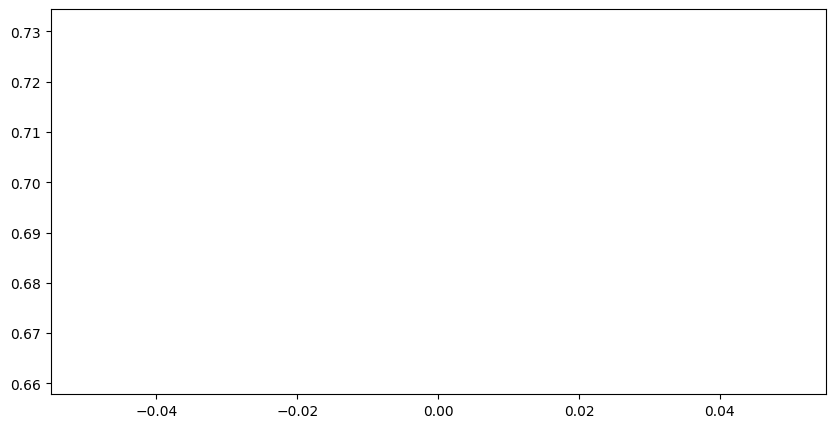

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(losses)